**clone coding for study**\
reference :  https://www.kaggle.com/xwxw2929/rossmann-sales-top1/notebook

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

get_ipython().run_line_magic('matplotlib','inline')
import xgboost as xgb
from time import time
import os

In [2]:
train= pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=[2])
test= pd.read_csv('../input/rossmann-store-sales/test.csv',parse_dates=[3])
store= pd.read_csv('../input/rossmann-store-sales/store.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [9]:
display(train.isnull().sum(), test.isnull().sum(), store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [10]:
test[pd.isnull(test.Open)]
#

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [11]:
store.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [12]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [13]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [14]:
NoPW= store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 !=0].shape

(0, 10)

<AxesSubplot:title={'center':'store1'}, xlabel='Date'>

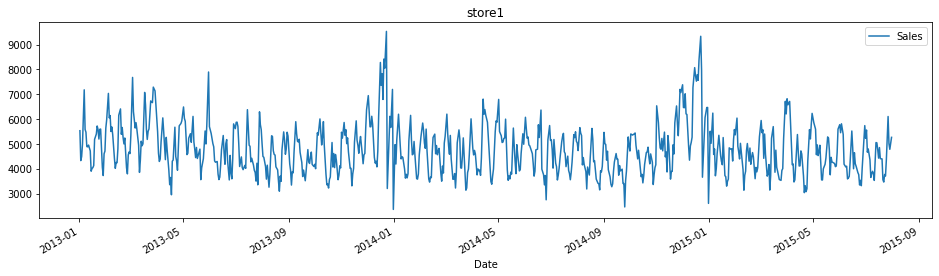

In [15]:
strain= train[train.Sales>0]
strain.loc[strain['Store']==1, ['Date', 'Sales']].plot(x='Date', y='Sales',title='store1', figsize=(16,4))

In [16]:
test.fillna(1, inplace=True)
store.fillna(0, inplace=True)

In [17]:
train=pd.merge(train, store, on='Store')
test=pd.merge(test, store, on='Store')

In [18]:
train= train.sort_values(['Date'], ascending=False)
ho_test= train[:6*7*1115]
ho_train= train[6*7*1115:]

In [19]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [20]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
           
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [21]:
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Features creation finished')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Features creation finished


In [22]:
ho_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
284584,314,4,2015-06-19,5032,562,1,1,0,0,1,...,2013.0,"Feb,May,Aug,Nov",2015,6,19,25,164.0,22.50,Jun,0
417104,458,4,2015-06-19,7362,688,1,1,0,0,3,...,0.0,,2015,6,19,25,24186.0,24186.25,Jun,0
875290,961,4,2015-06-19,7764,768,1,1,0,0,4,...,0.0,,2015,6,19,25,24186.0,24186.25,Jun,0
119580,132,4,2015-06-19,7964,692,1,1,0,0,4,...,2012.0,"Jan,Apr,Jul,Oct",2015,6,19,25,24186.0,35.50,Jun,0
807974,887,4,2015-06-19,7776,632,1,1,0,0,4,...,2009.0,"Jan,Apr,Jul,Oct",2015,6,19,25,24186.0,69.00,Jun,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864127,948,1,2013-01-01,4491,1039,1,0,1,1,2,...,0.0,,2013,1,1,1,24157.0,24156.25,Jan,0
321485,353,1,2013-01-01,3139,820,1,0,1,1,2,...,2013.0,"Feb,May,Aug,Nov",2013,1,1,1,24157.0,0.00,Jan,0
249459,274,1,2013-01-01,3102,729,1,0,1,1,2,...,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,24157.0,0.00,Jan,1
235513,259,1,2013-01-01,6851,1444,1,0,1,1,2,...,0.0,,2013,1,1,1,24157.0,24156.25,Jan,0


In [23]:
ho_train.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

<AxesSubplot:>

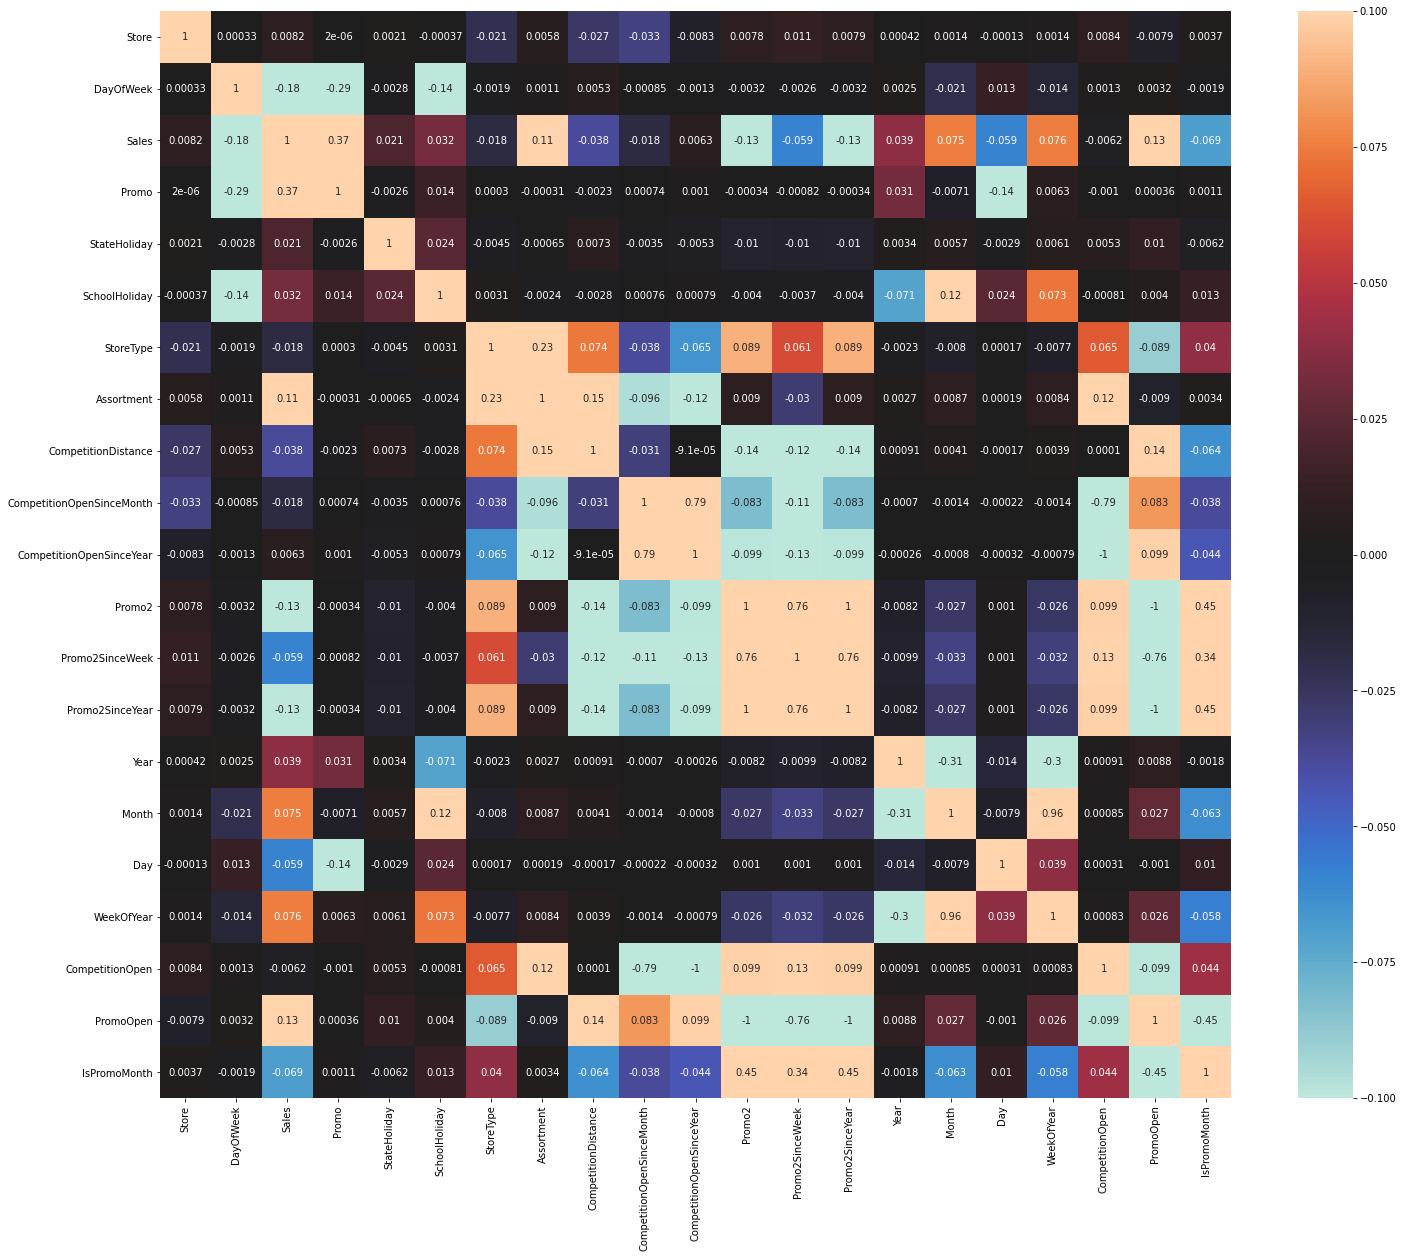

In [24]:
plt.subplots(figsize=(24,20))
sns.heatmap(ho_train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [25]:
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [26]:
xtest =test.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [27]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [28]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 6000


dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[15:29:47] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[15:29:47] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8.02074	train-rmspe:0.99981	eval-rmse:8.02788	eval-rmspe:0.99981
[1]	train-rmse:7.78061	train-rmspe:0.99971	eval-rmse:7.78786	eval-rmspe:0.99971
[2]	train-rmse:7.54775	train-rmspe:0.99959	eval-rmse:7.55443	eval-rmspe:0.99960
[3]	train-rmse:7.32190	train-rmspe:0.99944	eval-rmse:7.32811	eval-rmspe:0.99945
[4]	train-rmse:7.10281	train-rmspe:0.99927	eval-rmse:7.10739	eval-rmspe:0.99927
[5]	train-rmse:6.89033	train-rmspe:0.99905	eval-rmse:6.89429	eval-rmspe:0.99906
[6]	train-rmse:6.68427	train-rmspe:0.99880	eval-rms

KeyboardInterrupt: 

In [ ]:
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

In [ ]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))

In [ ]:
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]

In [ ]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

In [ ]:
# correction by store
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())


In [ ]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

In [ ]:
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)

# model1  kaggle private score 0.12647
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)

# model2 kaggle private score 0.11756
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
result.to_csv("Rossmann_submission_2.csv", index=False)

# model3 kaggle private score 0.11292
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)